<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Load data</a></span></li></ul></li><li><span><a href="#Tour-Scheduling" data-toc-modified-id="Tour-Scheduling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tour Scheduling</a></span></li><li><span><a href="#Tour-OD-Choice" data-toc-modified-id="Tour-OD-Choice-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Tour OD Choice</a></span></li><li><span><a href="#Tour-Mode-Choice" data-toc-modified-id="Tour-Mode-Choice-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tour Mode Choice</a></span></li><li><span><a href="#Stop-Frequency" data-toc-modified-id="Stop-Frequency-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stop Frequency</a></span></li><li><span><a href="#Trip-Purpose" data-toc-modified-id="Trip-Purpose-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Trip Purpose</a></span></li><li><span><a href="#Trip-Scheduling" data-toc-modified-id="Trip-Scheduling-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Trip Scheduling</a></span></li><li><span><a href="#Trip-Destination" data-toc-modified-id="Trip-Destination-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Trip Destination</a></span></li><li><span><a href="#Trip-Mode-Choice" data-toc-modified-id="Trip-Mode-Choice-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Trip Mode Choice</a></span></li></ul></div>

In [169]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Imports 

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

### Load data

In [165]:
ctramp_trips = pd.read_csv('../../../../../../projects/sandag-cb/output/crossBorderTrips.csv')
ctramp_tours = pd.read_csv('../../../../../../projects/sandag-cb/output/crossBorderTours.csv')

mode_ids = {1: 'DRIVEALONE', 2:'SHARED2', 3:'SHARED3', 4:'WALK', 6:'WALK_TRANSIT', 10:'TAXI', 11:'TNC_SINGLE', 12:'TNC_SHARED'}
purpose_ids = {-1: 'home', 0:'work', 1:'school', 2:'cargo', 3:'shop', 4:'visit', 5:'other'}

ctramp_tours['tour_mode'] = ctramp_tours['tourMode'].map(mode_ids)
ctramp_trips['trip_mode'] = ctramp_trips['tripMode'].map(mode_ids)

ctramp_tours['tour_purpose'] = ctramp_tours['purpose'].map(purpose_ids)

ctramp_trips['orig_purpose'] = ctramp_trips['originPurp'].map(purpose_ids)
ctramp_trips['dest_purpose'] = ctramp_trips['destPurp'].map(purpose_ids)

In [4]:
asim_trips = pd.read_csv('output/final_trips.csv')
asim_tours = pd.read_csv('output/final_tours.csv')

In [5]:
ctramp_trips = ctramp_trips.merge(ctramp_tours[['id','tour_purpose']], left_on='tourID', right_on='id') 

## Tour Scheduling 

Text(0.5, 0, 'tour departure hour')

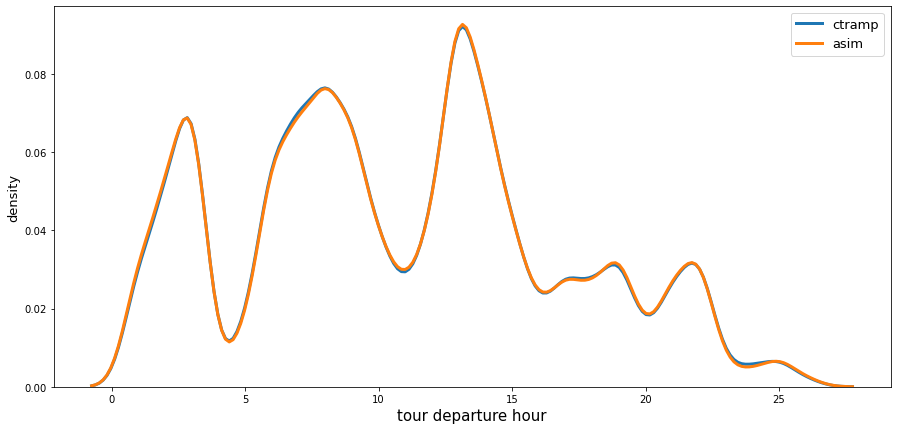

In [6]:
fig, ax = plt.subplots(figsize=(15,7))
sns.kdeplot(data=ctramp_tours, x='departTime', ax=ax, label='ctramp', alpha=0.5, lw=3)
sns.kdeplot(data=asim_tours, x='start', ax=ax, label='asim', alpha=0.5, lw=3)
ax.legend(fontsize=13)
ax.set_ylabel('density', fontsize=13)
ax.set_xlabel('tour departure hour', fontsize=15)

## Tour OD Choice 

In [9]:
mazs = pd.read_csv('data/mazs_xborder.csv')
mazs.set_index('MAZ', inplace=True)

asim_tours['dest_pseudomsa'] = asim_tours['destination'].map(mazs['pseudomsa'])
ctramp_tours['dest_pseudomsa'] = ctramp_tours['destinationMGRA'].map(mazs['pseudomsa'])
asim_tour_ods = asim_tours.groupby(['origin','dest_pseudomsa'])['tour_id'].count().reset_index()
ctramp_tour_ods = ctramp_tours.groupby(['originMGRA','dest_pseudomsa'])['id'].count().reset_index()
ctramp_tour_ods.rename(columns={'originMGRA': 'origin'}, inplace=True)

all_ods = pd.merge(
    asim_tour_ods, ctramp_tour_ods, left_on=['origin','dest_pseudomsa'],
    right_on=['origin','dest_pseudomsa'], how='outer')
all_ods.rename(columns={'id':'ctramp', 'tour_id':'asim'}, inplace=True)
all_ods['asim'] = all_ods['asim'].fillna(0)
all_ods['ctramp'] = all_ods['ctramp'].fillna(0)

all_ods = all_ods.melt(id_vars=['origin','dest_pseudomsa'], var_name='source', value_name='num_tours')

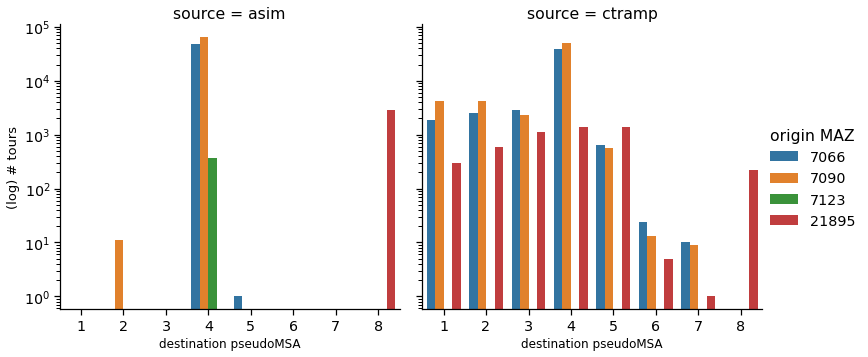

In [12]:
with sns.plotting_context("notebook",font_scale=1.3):
    g = sns.catplot(
        data=all_ods, x='dest_pseudomsa', y='num_tours', hue='origin',kind='bar', col='source',
        aspect=1.1, legend_out=True)
    g._legend.set_title('origin MAZ')
    g.fig.get_axes()[0].set_yscale('log')
    g.axes[0,0].set_ylabel('(log) # tours', fontsize=15)
    g.axes[0,0].set_xlabel('destination pseudoMSA', fontsize=12)
    g.axes[0,1].set_xlabel('destination pseudoMSA', fontsize=12)

## Tour Mode Choice

Text(0.5, 0, 'tour mode')

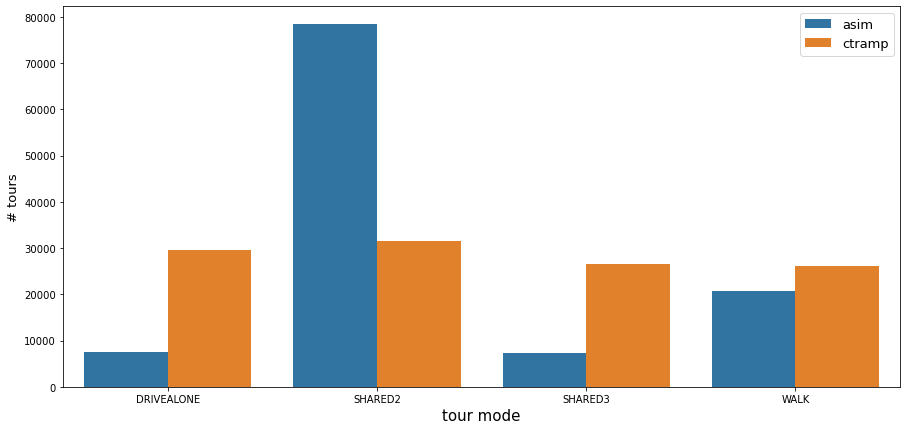

In [8]:
fig, ax = plt.subplots(figsize=(15,7))
tour_mode = asim_tours.groupby('tour_mode')['tour_id'].count()
tour_mode = pd.merge(tour_mode, ctramp_tours.groupby('tour_mode')['id'].count(), left_index=True, right_index=True).reset_index()
tour_mode.columns = ['tour_mode','asim','ctramp']
tour_mode = tour_mode.melt(id_vars='tour_mode',var_name='source',value_name='num_tours')
sns.barplot(
    data=tour_mode, x='tour_mode', y='num_tours', order=['DRIVEALONE','SHARED2','SHARED3','WALK'],
    hue='source', ax=ax)
ax.legend(fontsize=13)
ax.set_ylabel('# tours', fontsize=15)
ax.set_xlabel('tour mode', fontsize=15)

## Stop Frequency

In [13]:
asim_tpt = asim_trips.groupby(['tour_id'])['trip_id'].count().value_counts().reset_index()
asim_tpt.columns = ['# trips', '# tours']
asim_tpt['source'] = 'asim'

In [21]:
ctramp_tpt = ctramp_trips.groupby(['tourID'])['tripID'].count().value_counts().reset_index()
ctramp_tpt.columns = ['# trips', '# tours']
ctramp_tpt['source'] = 'ctramp'

In [22]:
all_tpt = pd.concat([asim_tpt,ctramp_tpt])

Text(0.5, 0, 'trips per tour')

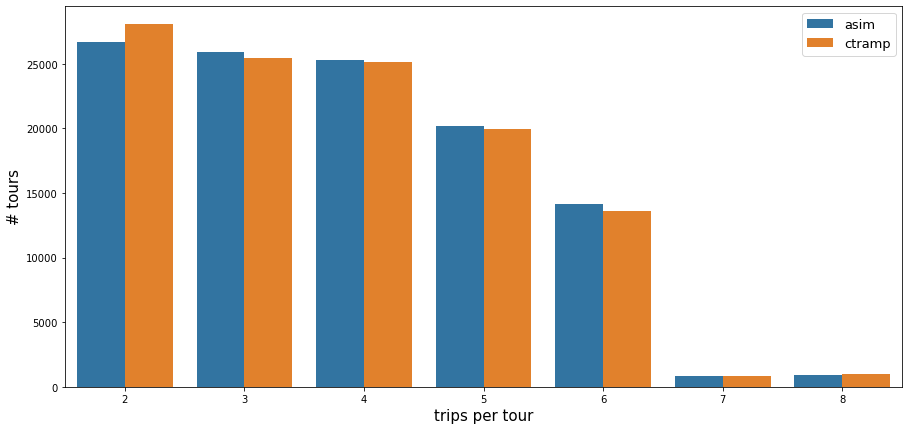

In [24]:
fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(data=all_tpt, x='# trips', y='# tours', hue='source', ax=ax)
ax.legend(fontsize=13)
ax.set_ylabel('# tours', fontsize=15)
ax.set_xlabel('trips per tour', fontsize=15)

## Trip Purpose 

In [37]:
asim_purp = asim_trips.groupby(['purpose'])['trip_id'].count().reset_index()
asim_purp.columns = ['purpose', '# trips']
asim_purp['source'] = 'asim'

In [38]:
ctramp_purp = ctramp_trips.groupby(['dest_purpose'])['tripID'].count().reset_index()
ctramp_purp.columns = ['purpose', '# trips']
ctramp_purp['source'] = 'ctramp'

In [39]:
all_purp = pd.concat([asim_purp, ctramp_purp])

Text(0.5, 0, 'trip purpose')

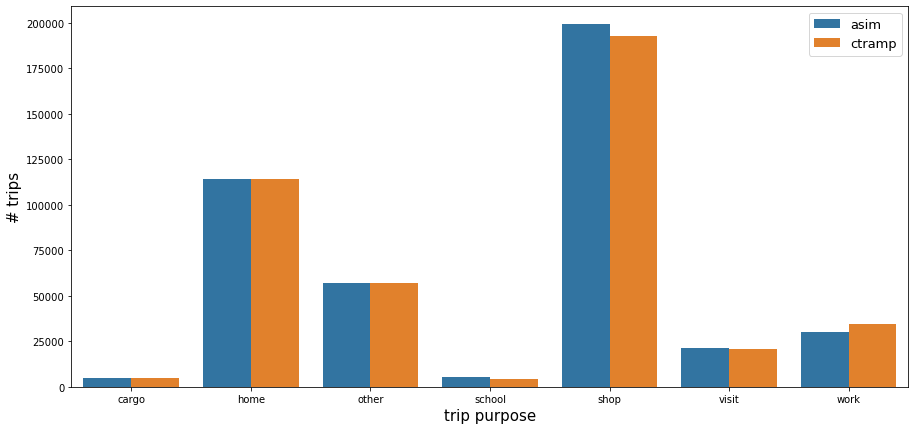

In [41]:
fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(data=all_purp, x='purpose', y='# trips', hue='source', ax=ax)
ax.legend(fontsize=13)
ax.set_ylabel('# trips', fontsize=15)
ax.set_xlabel('trip purpose', fontsize=15)

In [54]:
asim_tpt = asim_trips.groupby(['tour_id', 'purpose'])['trip_id'].count().reset_index()
asim_tpt.rename(columns={'trip_id': 'trips per tour', 'tour_id': '# tours', 'purpose': 'trip purpose'}, inplace=True)
asim_tpt = asim_tpt.groupby(['trip purpose', 'trips per tour']).count().reset_index()
asim_tpt['source'] = 'asim'

In [55]:
ctramp_tpt = ctramp_trips.groupby(['tourID', 'dest_purpose'])['tripID'].count().reset_index()
ctramp_tpt.rename(columns={'tripID': 'trips per tour', 'tourID': '# tours', 'dest_purpose': 'trip purpose'}, inplace=True)
ctramp_tpt = ctramp_tpt.groupby(['trip purpose', 'trips per tour']).count().reset_index()
ctramp_tpt['source'] = 'ctramp'

In [56]:
all_tpt = pd.concat([asim_tpt, ctramp_tpt])

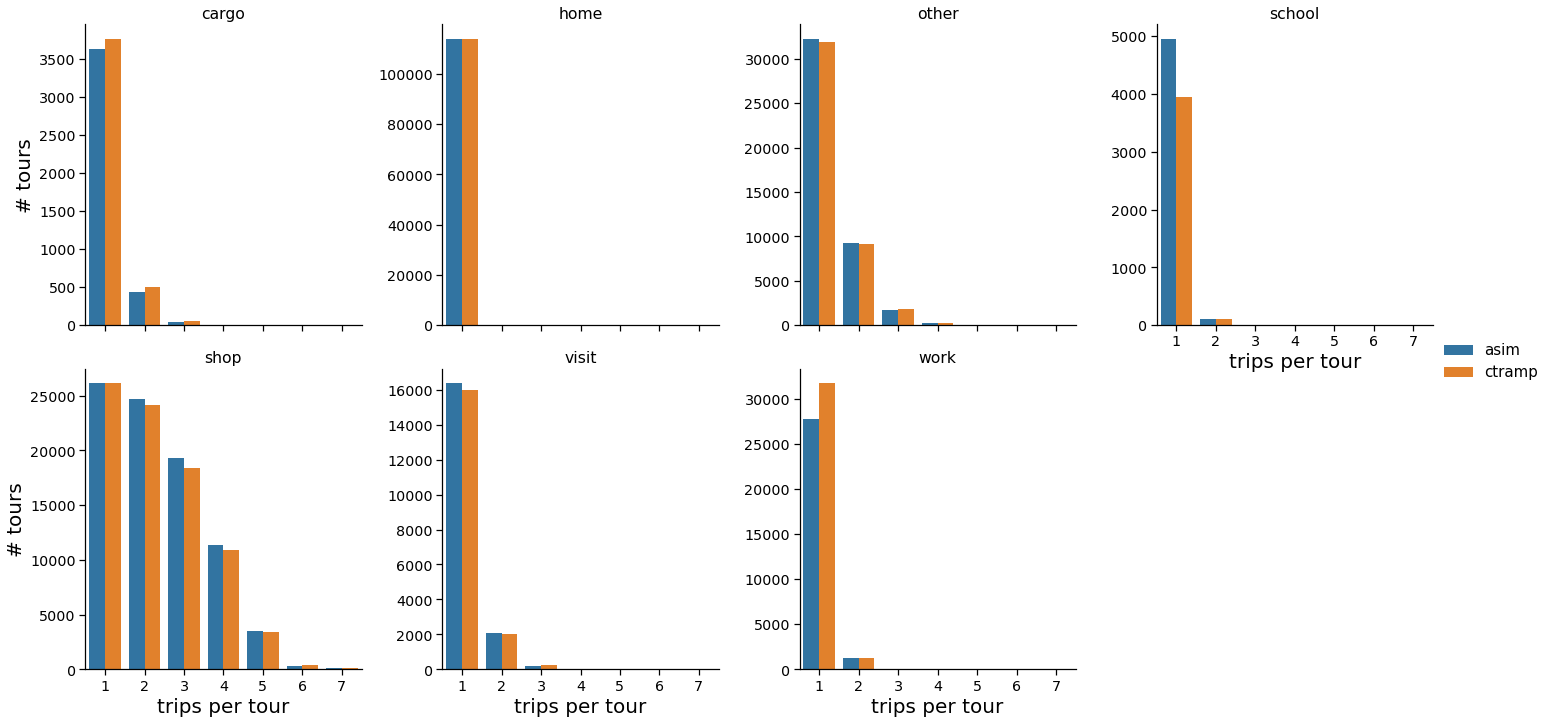

In [79]:
with sns.plotting_context("notebook",font_scale=1.3):
    g = sns.catplot(
        data=all_tpt, x='trips per tour', y='# tours', kind='bar', hue='source', col='trip purpose',
        col_wrap=4, sharey=False, )
    g._legend.set_title('')
    plt.setp(g._legend.get_texts(), fontsize=15)
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("trips per tour", "# tours", fontsize=20)
#     g.axes[0,0].set_ylabel('(log) # tours', fontsize=15)
#     g.axes[0,0].set_xlabel('destination pseudoMSA', fontsize=12)
#     g.axes[0,1].set_xlabel('destination pseudoMSA', fontsize=12)

## Trip Scheduling 

Text(0.5, 0, 'trip departure hour (outbound)')

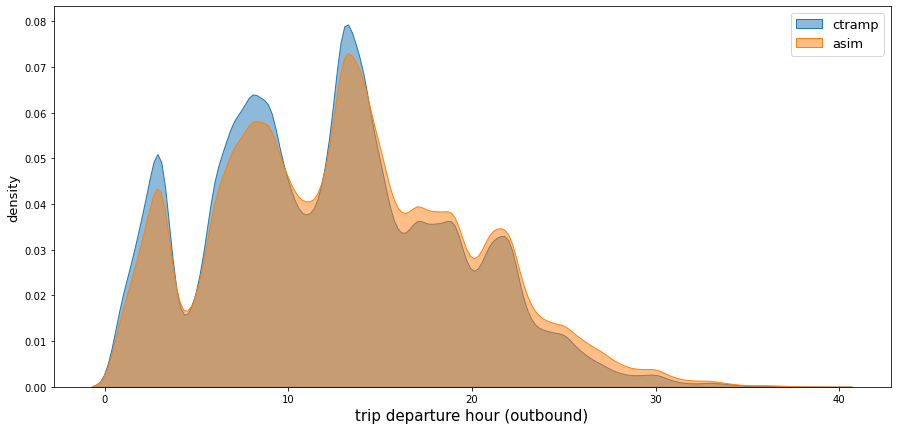

In [90]:
fig, ax = plt.subplots(figsize=(15,7))
sns.kdeplot(data=ctramp_trips[~ctramp_trips['inbound']], x='period', ax=ax, label='ctramp', alpha=0.5, shade=True)
sns.kdeplot(data=asim_trips[asim_trips['outbound']], x='depart', ax=ax, label='asim', alpha=0.5, shade=True)
ax.legend(fontsize=13)
ax.set_ylabel('density', fontsize=13)
ax.set_xlabel('trip departure hour (outbound)', fontsize=15)

Text(0.5, 0, 'trip departure hour (inbound)')

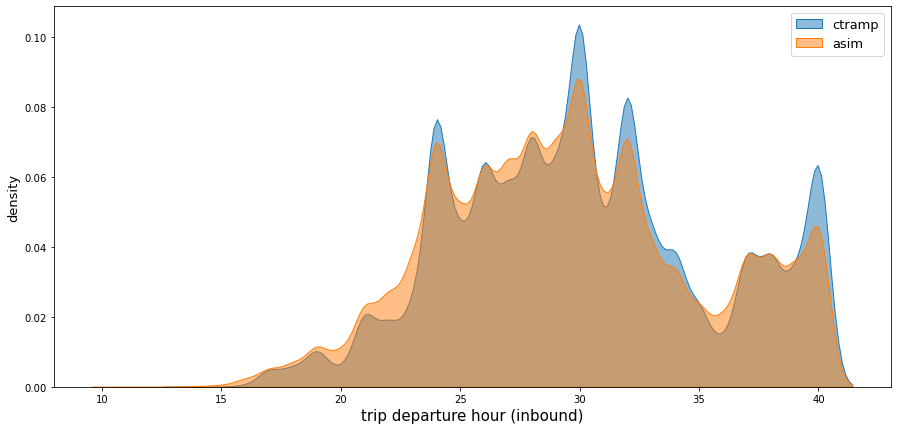

In [92]:
fig, ax = plt.subplots(figsize=(15,7))
sns.kdeplot(data=ctramp_trips[ctramp_trips['inbound']], x='period', ax=ax, label='ctramp', alpha=0.5, shade=True)
sns.kdeplot(data=asim_trips[~asim_trips['outbound']], x='depart', ax=ax, label='asim', alpha=0.5, shade=True)
ax.legend(fontsize=13)
ax.set_ylabel('density', fontsize=13)
ax.set_xlabel('trip departure hour (inbound)', fontsize=15)

## Trip Destination 

In [81]:
asim_trips.columns

Index(['trip_id', 'person_id', 'household_id', 'primary_purpose', 'trip_num',
       'outbound', 'trip_count', 'destination', 'origin', 'failed', 'tour_id',
       'purpose', 'depart', 'destination_logsum', 'trip_mode',
       'trip_mode_choice_logsum', 'atap', 'btap', 'path_set'],
      dtype='object')

In [119]:
asim_trips['dest_pseudomsa'] = asim_trips['destination'].map(mazs['pseudomsa'])
asim_trips['orig_pseudomsa'] = asim_trips['origin'].map(mazs['pseudomsa'])
ctramp_trips['dest_pseudomsa'] = ctramp_trips['destinationMGRA'].map(mazs['pseudomsa'])
ctramp_trips['orig_pseudomsa'] = ctramp_trips['originMGRA'].map(mazs['pseudomsa'])

asim_trip_ods = asim_trips.groupby(['orig_pseudomsa','dest_pseudomsa'])['trip_id'].count().reset_index()
asim_trip_ods.columns=['origin pMSA', 'destination pMSA', '# trips']
asim_trip_ods = asim_trip_ods.pivot(index='origin pMSA', columns='destination pMSA',values='# trips')
ctramp_trip_ods = ctramp_trips.groupby(['orig_pseudomsa','dest_pseudomsa'])['tripID'].count().reset_index()
ctramp_trip_ods.columns=['origin pMSA', 'destination pMSA', '# trips']
ctramp_trip_ods = ctramp_trip_ods.pivot(index='origin pMSA', columns='destination pMSA',values='# trips')



Text(0.5, 0.98, 'Trip OD Counts')

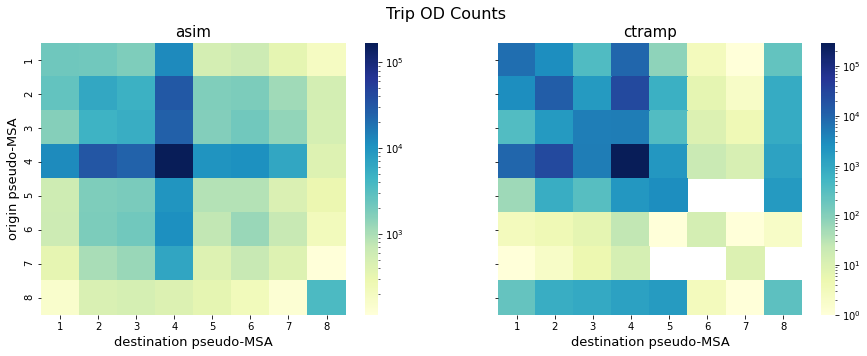

In [163]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,5))
vmin = min(asim_trip_ods.values.min(), ctramp_trip_ods.values.min())
vmax = min(asim_trip_ods.values.max(), ctramp_trip_ods.values.max())

sns.heatmap(asim_trip_ods, ax=ax[0], cmap="YlGnBu", cbar=True, vmin=vmin, vmax=vmax, norm=LogNorm())
g = sns.heatmap(ctramp_trip_ods, ax=ax[1],cmap="YlGnBu", cbar=True, vmin=vmin, vmax=vmax, norm=LogNorm())
ax[0].set_title('asim', fontsize=15)
ax[0].set_ylabel('origin pseudo-MSA', fontsize=13)
ax[0].set_xlabel('destination pseudo-MSA', fontsize=13)
ax[1].set_title('ctramp', fontsize=15)
ax[1].set_ylabel('')
ax[1].set_xlabel('destination pseudo-MSA', fontsize=13)
fig.suptitle('Trip OD Counts', fontsize=16)

## Trip Mode Choice 

Text(0.5, 0, 'trip mode')

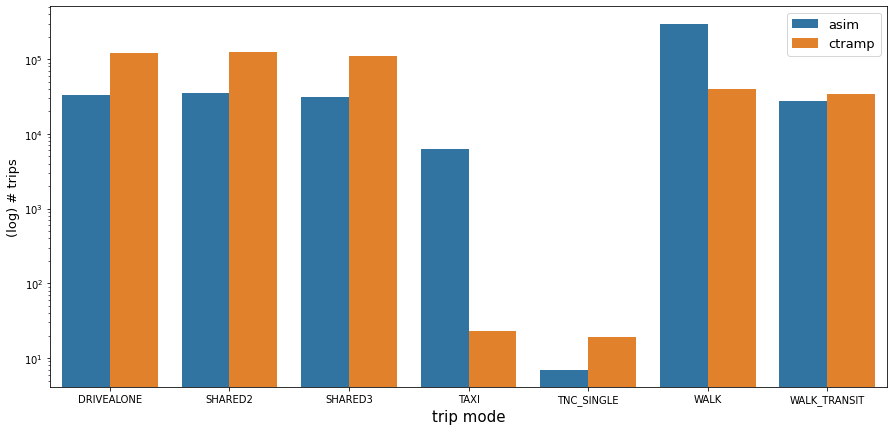

In [167]:
fig, ax = plt.subplots(figsize=(15,7))
trip_mode = asim_trips.groupby('trip_mode')['trip_id'].count()
trip_mode = pd.merge(
    trip_mode, ctramp_trips.groupby('trip_mode')['tripID'].count(),
    left_index=True, right_index=True, how='outer').reset_index()
trip_mode.columns = ['trip_mode','asim','ctramp']
trip_mode = trip_mode.melt(id_vars='trip_mode',var_name='source',value_name='num_trips')
g = sns.barplot(
    data=trip_mode, x='trip_mode', y='num_trips', 
    hue='source', ax=ax)
g.set_yscale("log")
ax.legend(fontsize=13)
ax.set_ylabel('(log) # trips', fontsize=13)
ax.set_xlabel('trip mode', fontsize=15)